In [1]:
import itertools
import pickle

import torch
from leela_interp import Lc0sight, LeelaBoard
from leela_interp.tools.attention import attention_attribution, top_k_attributions
from leela_interp.tools.patching import activation_patch

# Run PCA on the attention values
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import gaussian_kde
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from collections import Counter
from scipy.stats import entropy

from time import sleep
from tqdm import tqdm

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = Lc0sight("lc0.onnx", device=device)

Using device: cpu


First, we load a dataset of puzzles selected to be challenging but solvable for Leela:

In [3]:
with open("interesting_puzzles.pkl", "rb") as f:
    puzzles = pickle.load(f)
len(puzzles)

22517

Let's look at one of these puzzles:

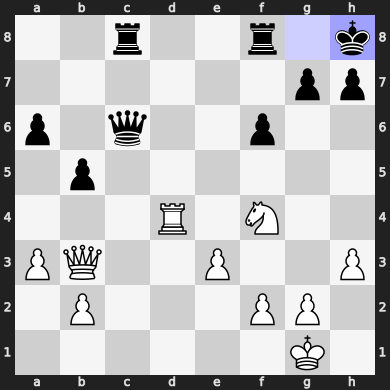

In [4]:
# This is the running example from the paper, you can pick a different one:
puzzle = puzzles.iloc[483]
# LeelaBoard instances can also be created from FENs or in other ways, but always
# use from_puzzle if you want to create one from a puzzle from the lichess dataset.
board = LeelaBoard.from_puzzle(puzzle)
board

The *principal variation* is the best sequence of moves for both sides:

In [5]:
puzzle.principal_variation

['f4g6', 'h7g6', 'd4h4']

Leela solves this puzzle correctly:

In [6]:
model.pretty_play(board)

Ng6+: 57.87%
a4: 9.01%
Kh2: 8.27%
h4: 8.08%
Qd3: 3.91%
W: 28.72%, D: 49.91%, L: 21.37%


# Visualizing attention patterns

Next, let's look at some attention patterns. These are 64 x 64 arrays, with one entry for each pair of squares.

In [4]:
boards = []
board_labels = []
good_puzzles = []
count_5 = 0
count_7 = 0
count_9 = 0
for i in range(len(puzzles[:10_000])):
    puzzle = puzzles.iloc[i]
    pv = puzzle.principal_variation
    mov_1, mov_2, mov_3 = pv[0], pv[1], pv[2]
    if len(pv) > 3:
        mov_4 = pv[3]
        mov_5 = pv[4]
        count_5 += 1
    if len(pv) > 5:
        mov_6 = pv[5]
        mov_7 = pv[6]
        count_7 += 1
    if mov_1[2:4] != mov_2[2:4]:
        continue
    if len(pv) > 7:
        mov_8 = pv[7]
        mov_9 = pv[8]
        count_9 += 1
    # if mov_1[2:4] != 'f1' and mov_1[2:4] != 'e8':
    #     continue
    check = mov_1[:4] + mov_2[:4] + mov_3[:4]
    if len(pv) > 3:
        check += mov_4[:4] + mov_5[:4]
    if len(pv) > 5:
        check += mov_6[:4] + mov_7[:4]
    if len(pv) > 7:
        check += mov_8[:4] + mov_9[:4]
    # if check != 'c8e8' and check != 'h7h5' and check != 'c8c8':
    #     continue
    board_labels.append(check)
    good_puzzles.append(puzzle)
    # LeelaBoard instances can also be created from FENs or in other ways, but always
    # use from_puzzle if you want to create one from a puzzle from the lichess dataset.
    board = LeelaBoard.from_puzzle(puzzle)
    boards.append(board)
print(count_5, count_7, count_9)

3808 371 58


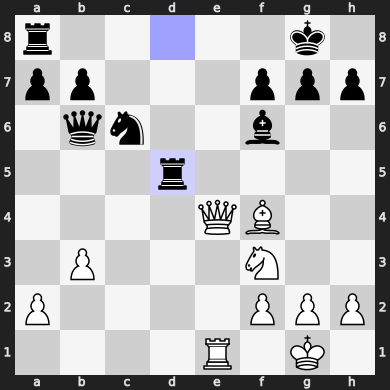

In [16]:
boards[0]

In [15]:
board_labels[0], good_puzzles[0]

('e8',
 PuzzleId                                                                 00aBq
 FEN                          r2r2k1/pp3ppp/1qn2b2/3R4/4QB2/1P3N2/P4PPP/4R1K...
 Moves                                                      d8d5 e4e8 a8e8 e1e8
 Rating                                                                     927
 RatingDeviation                                                             83
 Popularity                                                                  88
 NbPlays                                                                    315
 Themes                       backRankMate mate mateIn2 middlegame sacrifice...
 GameUrl                                  https://lichess.org/0AybhVJm/black#35
 OpeningTags                    Queens_Pawn_Game Queens_Pawn_Game_London_System
 principal_variation                                         [e4e8, a8e8, e1e8]
 full_pv_probs                    [0.8980200290679932, 1.0, 0.7761741876602173]
 full_model_moves                

In [63]:
len(boards)

387

In [31]:
# Order boards by frequency of the 2nd and 3rd characters of the third move
puzzle_counts = {}
for i in range(len(puzzles)):
    puzzle = puzzles.iloc[i]
    pv = puzzle.principal_variation
    mov_1, mov_2, mov_3 = pv[0], pv[1], pv[2]
    if mov_1[2:4] != mov_2[2:4]:
        continue
    if mov_3[2:4] not in puzzle_counts:
        puzzle_counts[mov_3[2:4]] = 1
    else:
        puzzle_counts[mov_3[2:4]] += 1



In [45]:
# Order boards by frequency of the 2nd and 3rd characters of the third move
puzzle_counts = {}
for i in range(len(puzzles)):
    puzzle = puzzles.iloc[i]
    pv = puzzle.principal_variation
    mov_1, mov_2, mov_3 = pv[0], pv[1], pv[2]
    if mov_1[2:4] != mov_2[2:4]:
        continue
    if mov_1[2:4] not in puzzle_counts:
        puzzle_counts[mov_1[2:4]] = 1
    else:
        puzzle_counts[mov_1[2:4]] += 1

In [33]:
# Order boards by frequency of the 2nd and 3rd characters of the third move
puzzle_counts = {}
for i in range(len(puzzles)):
    puzzle = puzzles.iloc[i]
    pv = puzzle.principal_variation
    mov_1, mov_2, mov_3 = pv[0], pv[1], pv[2]
    if mov_1[2:4] != mov_2[2:4]:
        continue
    if mov_1[2:4]+mov_3[2:4] not in puzzle_counts:
        puzzle_counts[mov_1[2:4]+mov_3[2:4]] = 1
    else:
        puzzle_counts[mov_1[2:4]+mov_3[2:4]] += 1

In [36]:
# Order puzzle_counts from most to least frequent
sorted_puzzle_counts = sorted(puzzle_counts.items(), key=lambda x: x[1], reverse=True)
sorted_puzzle_counts

[('e8e8', 719),
 ('e1e1', 604),
 ('d8d8', 480),
 ('f8f8', 462),
 ('f1f1', 397),
 ('d1d1', 387),
 ('c1c1', 152),
 ('c8c8', 146),
 ('c8e8', 122),
 ('h7h5', 119),
 ('f7d8', 103),
 ('c1e1', 93),
 ('f7e8', 92),
 ('h7g5', 90),
 ('d1e1', 85),
 ('d8e8', 83),
 ('f8d8', 82),
 ('h7d4', 82),
 ('g3h6', 79),
 ('f6d5', 75),
 ('g3h5', 73),
 ('h2h4', 73),
 ('c8e7', 72),
 ('f7g5', 70),
 ('h7c3', 69),
 ('f8e6', 68),
 ('h7h7', 67),
 ('g7e6', 66),
 ('f6f6', 65),
 ('f7f7', 64),
 ('f1d1', 63),
 ('g2f4', 62),
 ('f7e5', 61),
 ('f2d1', 58),
 ('h7h3', 58),
 ('f6h7', 57),
 ('h1f2', 57),
 ('g8g8', 56),
 ('g6h3', 56),
 ('h2h8', 56),
 ('h8f7', 56),
 ('g8f7', 55),
 ('g2e3', 55),
 ('g7g7', 52),
 ('c1e2', 52),
 ('c8d8', 50),
 ('g5g5', 50),
 ('g2g2', 49),
 ('g3g3', 48),
 ('c6a6', 48),
 ('g8f6', 48),
 ('g1f3', 48),
 ('f3d4', 48),
 ('g7f5', 47),
 ('f1e3', 46),
 ('h7f8', 46),
 ('h7h1', 45),
 ('d5d5', 45),
 ('h2d4', 44),
 ('h7d5', 44),
 ('d7f6', 44),
 ('h8h7', 44),
 ('d4d4', 42),
 ('c1d1', 42),
 ('g1g1', 42),
 ('d4e2', 41),

In [5]:
def mutual_information_PCA(scores, solutions):
    x_prob, y_prob, xy_prob = {}, {}, {}
    for score, solution in zip(scores, solutions):
        x_prob[score] = x_prob.get(score, 0) + 1
        y_prob[solution] = y_prob.get(solution, 0) + 1
        xy_prob[(score, solution)] = xy_prob.get((score, solution), 0) + 1

    mi = 0
    for x, y in xy_prob:
        p_xy = xy_prob[(x, y)] / len(scores)
        p_x = x_prob[x] / len(scores)
        p_y = y_prob[y] / len(scores)
        mi += p_xy * np.log2(p_xy / (p_x * p_y))

    return mi

In [7]:
n_layers = 15
attention_arr = np.zeros((n_layers, len(boards), 64, 768))
for i, layer in enumerate(tqdm(range(0, n_layers, 2))):
    with model.trace(boards):
        attention = model.residual_stream(layer).output.save()
    attention_arr[layer] = attention.cpu().numpy()

100%|██████████| 8/8 [25:54<00:00, 194.26s/it]


In [8]:
# Save attention_arr
with open("attention_arr.pkl", "wb") as f:
    pickle.dump(attention_arr, f)

In [6]:
# Import attention_arr
with open("attention_arr.pkl", "rb") as f:
    attention_arr = pickle.load(f)

In [9]:
# n_clusters = 256
# cluster_assignments = {}
# for i, layer in enumerate(range(0, 15, 4)):
#     with model.trace(boards):
#         attention = model.residual_stream(layer).output.save()
#     attention_dist = attention.reshape(attention.shape[0], -1)
#     pca = PCA(n_components=256)
#     pca.fit(attention_dist)
#     attention_pca = pca.transform(attention_dist)

#     # Perform KMeans clustering on the original (unsorted) PCA results
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     cluster_labels = kmeans.fit_predict(attention_pca)
    
#     # Store cluster assignments in original order
#     cluster_assignments[i] = cluster_labels

# # MI scores for each layer
# n_layers = 15
# PCA_comps = [2, 4, 8]
# clusters = [2, 4, 8, 16]
# mi_scores_first = np.zeros((len(PCA_comps), len(clusters), n_layers))
# mi_scores_third = np.zeros((len(PCA_comps), len(clusters), n_layers))

# for i, layer in enumerate(range(n_layers)):
#     with model.trace(boards):
#         attention = model.residual_stream(layer).output.save()
#     attention_dist = attention.reshape(attention.shape[0], -1)

#     # Perform PCA on the attention values
#     for j, n_components in enumerate(PCA_comps):

#         pca = PCA(n_components=n_components)
#         pca.fit(attention_dist)
#         attention_pca = pca.transform(attention_dist)

#         # Perform KMeans clustering on the original (unsorted) PCA results
#         for k, n_clusters in enumerate(clusters):
#             kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#             cluster_labels = kmeans.fit_predict(attention_pca)
#             mi_scores_first[j, k, layer] = mutual_information_PCA(cluster_labels, [label[:2] for label in board_labels])
#             mi_scores_third[j, k, layer] = mutual_information_PCA(cluster_labels, [label[2:4] for label in board_labels])

In [7]:
moves_data = {}

for i in range(9):  # Up to the 9th move (both A and B)
    moves_data[i+1] = {'A': {}, 'B': {}}
    
    for player in ['A', 'B']:
        start_index = i * 4 + (0 if player == 'A' else 2)
        
        moves_data[i+1][player] = {
            'moves': [board_label[start_index:start_index+2] for board_label in board_labels if len(board_label) > start_index+1],
            'indices': np.array([j for j, board_label in enumerate(board_labels) if len(board_label) > start_index+1])
        }

# If you need quick access to specific moves, you can use:
# moves_data[1]['A']['moves'] for first_moves_A
# moves_data[1]['B']['moves'] for first_moves_B
# moves_data[2]['A']['moves'] for second_moves_A
# and so on...

# Similarly for indices:
# moves_data[4]['A']['indices'] for fourth_moves_A_index
# moves_data[4]['B']['indices'] for fourth_moves_B_index
# and so on...

In [8]:
# Calculate entropy for each move
entropies = {}

for i in range(1, 6):  # For moves 1 to 5
    entropies[i] = {}
    for player in ['A', 'B']:
        moves = moves_data[i][player]['moves']
        move_counts = Counter(moves)
        entropies[i][player] = entropy([v for v in move_counts.values()], base=2)

# Return the entropy values as a tuple
tuple(entropies[i][player] for i in range(1, 6) for player in ['A', 'B'])

(5.770588037122102,
 5.510347236462436,
 5.567384687648902,
 5.510347236462436,
 5.645685625483796,
 5.667858006169727,
 5.490207825721022,
 5.568783999638172,
 5.744515510798488,
 5.824943321128445)

In [10]:
# MI scores for each layer
n_layers = 15
PCA_comps = [2, 8, 32, 128, 512, None]
clusters = [2, 8, 32, 128, 512]

mi_scores = {
    i: {
        'A': np.zeros((len(PCA_comps), len(clusters), n_layers)),
        'B': np.zeros((len(PCA_comps), len(clusters), n_layers))
    } for i in range(1, 6)
}

# Perform PCA on the attention values
for i, layer in enumerate(range(n_layers)):
    attention_dist = attention_arr[layer].reshape(attention_arr[layer].shape[0], -1)
    for j, n_components in enumerate(PCA_comps):
        if n_components is None:
            attention_pca = attention_dist
        else:
            pca = PCA(n_components=n_components)
            pca.fit(attention_dist)
            attention_pca = pca.transform(attention_dist)

        # Perform KMeans clustering on the original (unsorted) PCA results
        for k, n_clusters in enumerate(clusters):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(attention_pca)
            
            for move_num in range(1, 6):
                for player in ['A', 'B']:
                    moves = moves_data[move_num][player]['moves']
                    indices = moves_data[move_num][player]['indices']
                    
                    if indices.size > 0:
                        mi_scores[move_num][player][j, k, layer] = mutual_information_PCA(
                            cluster_labels[indices], moves
                        )
                    else:
                        mi_scores[move_num][player][j, k, layer] = 0

/home/dcruz/anaconda3/envs/leela/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
/home/dcruz/anaconda3/envs/leela/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/dcruz/anaconda3/envs/leela/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/dcruz/anaconda3/envs/leela/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (32). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/hom

In [12]:


# n_layers = 15
# mi_scores_first_A = np.zeros((n_layers))
# mi_scores_first_B = np.zeros((n_layers))
# mi_scores_second_A = np.zeros((n_layers))
# mi_scores_second_B = np.zeros((n_layers))
# mi_scores_third_A = np.zeros((n_layers))
# mi_scores_third_B = np.zeros((n_layers))
# mi_scores_fourth_A = np.zeros((n_layers))
# mi_scores_fourth_B = np.zeros((n_layers))
# mi_scores_fifth_A = np.zeros((n_layers))
# mi_scores_fifth_B = np.zeros((n_layers))
# #main_solutions = [solution for i, solution in enumerate(solutions) if i in main_indices]
# for i, layer in enumerate(range(0, n_layers, 4)):
#     local_scores = cluster_assignments[i]
#     mi_scores_first_A[layer] = mutual_information_PCA(local_scores, first_moves_A)
#     mi_scores_first_B[layer] = mutual_information_PCA(local_scores, first_moves_B)
#     mi_scores_second_A[layer] = mutual_information_PCA(local_scores, second_moves_A)
#     mi_scores_second_B[layer] = mutual_information_PCA(local_scores, second_moves_B)
#     mi_scores_third_A[layer] = mutual_information_PCA(local_scores, third_moves_A)
#     mi_scores_third_B[layer] = mutual_information_PCA(local_scores, third_moves_B)
#     mi_scores_fourth_A[layer] = mutual_information_PCA(local_scores[fourth_moves_A_index], fourth_moves_A)
#     mi_scores_fourth_B[layer] = mutual_information_PCA(local_scores[fourth_moves_B_index], fourth_moves_B)
#     mi_scores_fifth_A[layer] = mutual_information_PCA(local_scores[fifth_moves_A_index], fifth_moves_A)
#     mi_scores_fifth_B[layer] = mutual_information_PCA(local_scores[fifth_moves_B_index], fifth_moves_B)

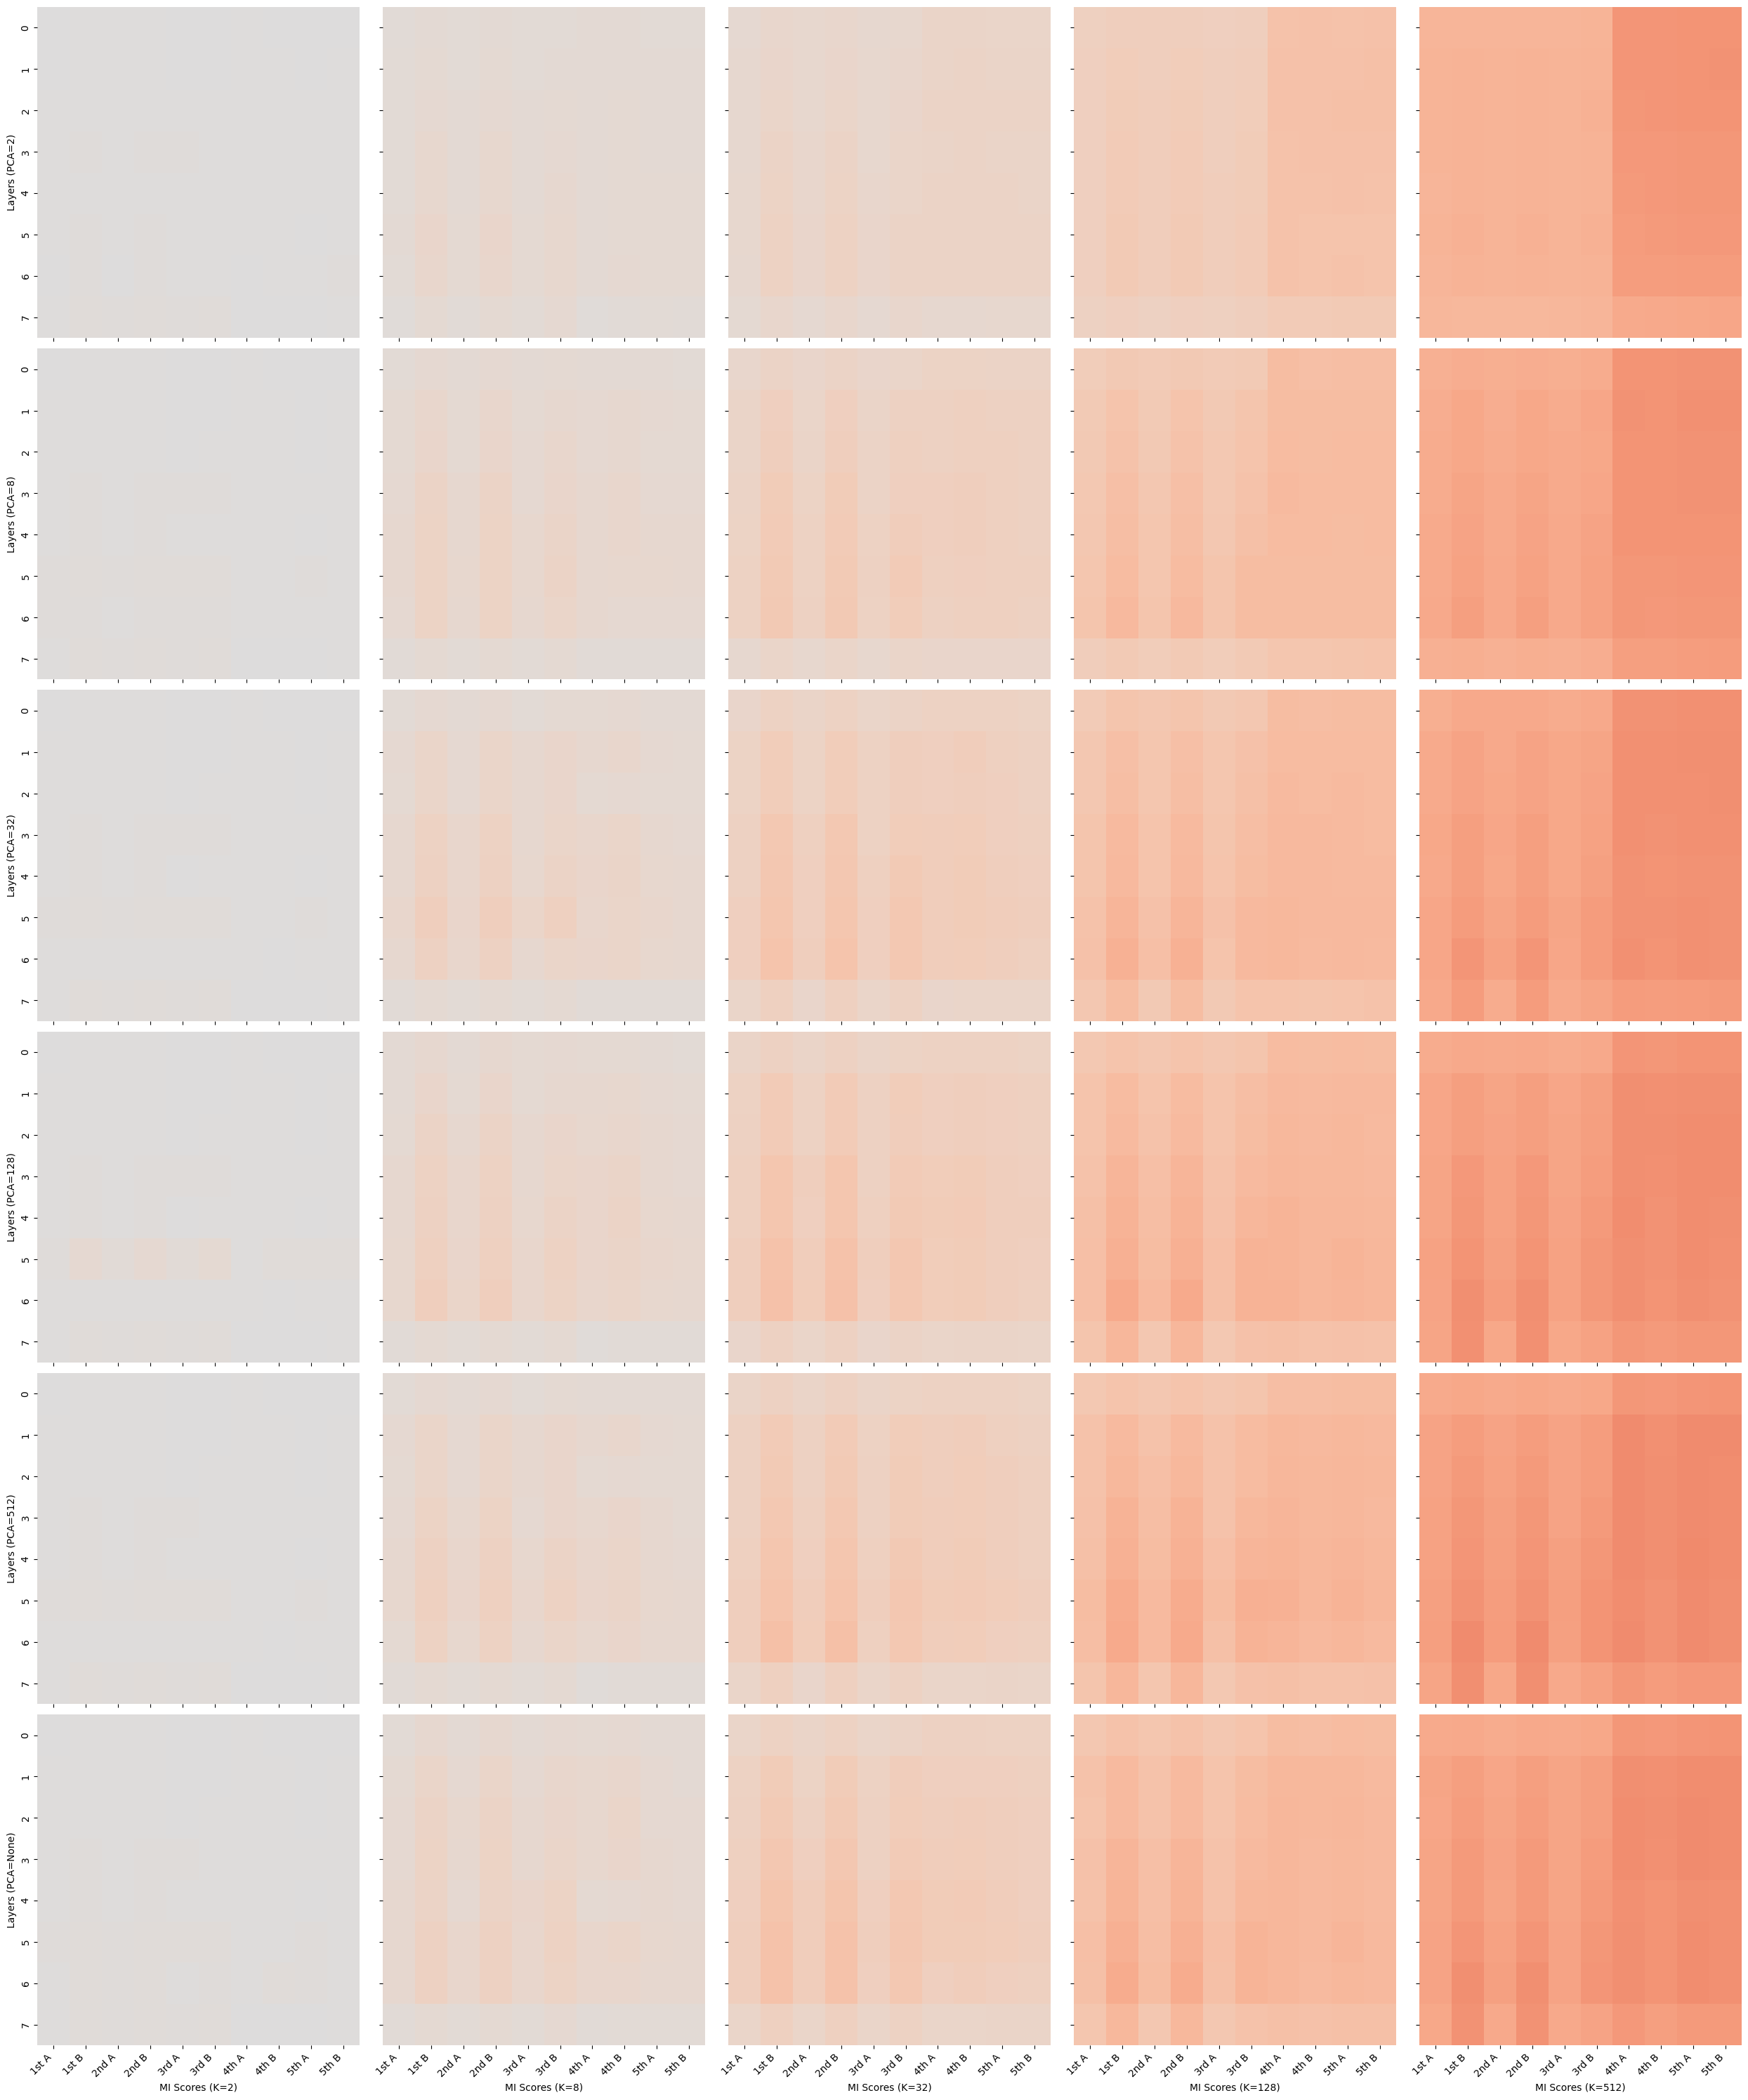

In [12]:
# Plot MI scores as heatmaps
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(PCA_comps), len(clusters), figsize=(5 * len(clusters), 5 * len(PCA_comps)), sharex=True, sharey=True)
titles = ["1st A", "1st B", "2nd A", "2nd B", "3rd A", "3rd B", "4th A", "4th B", "5th A", "5th B"]

for i, n_components in enumerate(PCA_comps):
    for j, n_clusters in enumerate(clusters):
        heatmap_data = np.zeros((n_layers // 2 + 1, len(titles)))
        for k, (move_num, player) in enumerate([(1, 'A'), (1, 'B'), (2, 'A'), (2, 'B'), 
                                                (3, 'A'), (3, 'B'), (4, 'A'), (4, 'B'), 
                                                (5, 'A'), (5, 'B')]):
            heatmap_data[:, k] = mi_scores[move_num][player][i, j, ::2] / entropies[move_num][player]
        
        sns.heatmap(heatmap_data, ax=axs[i, j], cmap="coolwarm", cbar=False, vmin=0, vmax=1, center=0)
        
        if i == len(PCA_comps) - 1:
            axs[i, j].set_xlabel(f"MI Scores (K={n_clusters})")
        if j == 0:
            axs[i, j].set_ylabel(f"Layers (PCA={n_components})")
        
        axs[i, j].set_xticks(np.arange(len(titles)) + 0.5)
        axs[i, j].set_xticklabels(titles, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Save PDF of plot with tight layout
fig.savefig("mi_toy_pca_heatmaps_2.pdf", bbox_inches="tight")

In [13]:
# # Plot MI scores as heatmaps
# import seaborn as sns

# fig, axs = plt.subplots(len(PCA_comps), len(clusters), figsize=(5 * len(clusters), 5 * len(PCA_comps)), sharex=True, sharey=True)
# mi_scores = [mi_scores_first_A, mi_scores_first_B, mi_scores_second_A, mi_scores_second_B, 
#              mi_scores_third_A, mi_scores_third_B, mi_scores_fourth_A, mi_scores_fourth_B, 
#              mi_scores_fifth_A, mi_scores_fifth_B]
# entropies = [first_move_entropy_A, first_move_entropy_B, second_move_entropy_A, second_move_entropy_B,
#              third_move_entropy_A, third_move_entropy_B, fourth_move_entropy_A, fourth_move_entropy_B,
#              fifth_move_entropy_A, fifth_move_entropy_B]
# titles = ["1st A", "1st B", "2nd A", "2nd B", "3rd A", "3rd B", "4th A", "4th B", "5th A", "5th B"]

# for i, n_components in enumerate(PCA_comps):
#     for j, n_clusters in enumerate(clusters):
#         heatmap_data = np.zeros((n_layers // 2 + 1, len(mi_scores)))
#         for k, (mi_score, entropy) in enumerate(zip(mi_scores, entropies)):
#             heatmap_data[:, k] = mi_score[i, j, ::2] / entropy
        
#         sns.heatmap(heatmap_data, ax=axs[i, j], cmap="coolwarm", cbar=False, vmin=0, vmax=1, center=0)
#         #axs[i, j].set_title(f"PCA={n_components}, K={n_clusters}")
        
#         if i == len(PCA_comps) - 1:
#             axs[i, j].set_xlabel(f"MI Scores (K={n_clusters})")
#         if j == 0:
#             axs[i, j].set_ylabel(f"Layers (PCA={n_components})")
        
#         axs[i, j].set_xticks(np.arange(len(titles)) + 0.5)
#         axs[i, j].set_xticklabels(titles, rotation=45, ha='right')

# plt.tight_layout()
# plt.show()

# # Save PDF of plot with tight layout
# fig.savefig("mi_toy_pca_heatmaps_2.pdf", bbox_inches="tight")

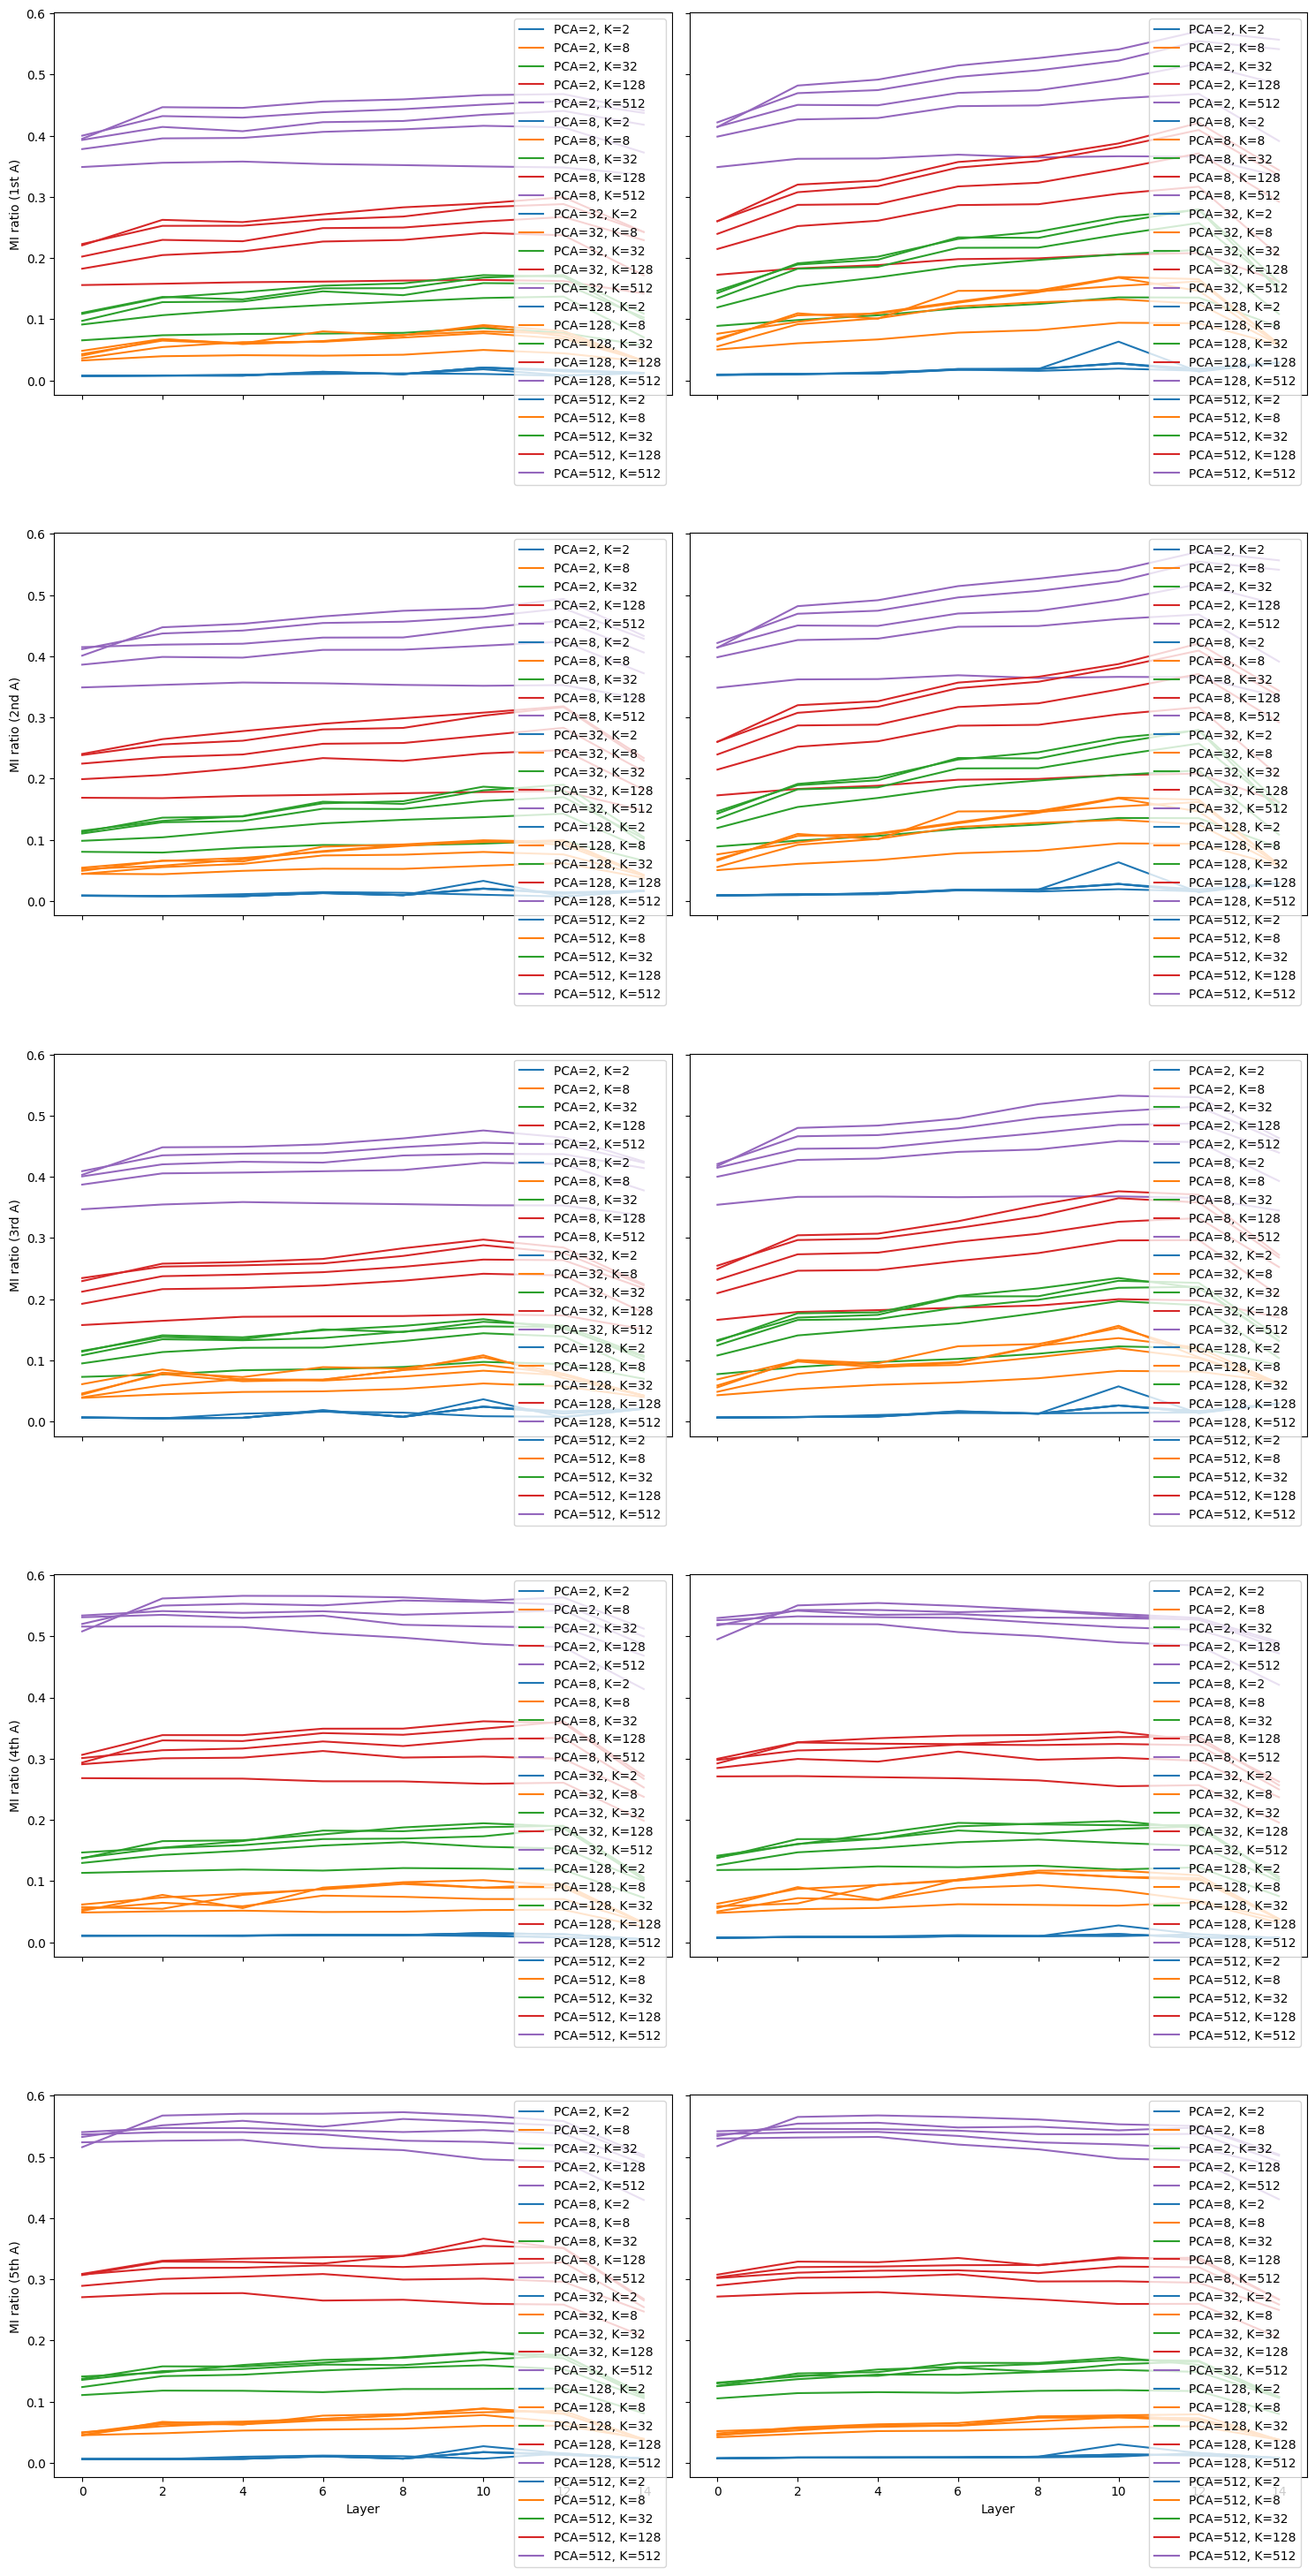

In [12]:
# Plot MI scores
fig, axs = plt.subplots(5, 2, figsize=(15, 30), sharex=True, sharey=True)
cmap = plt.get_cmap("tab10")
mi_scores = [mi_scores_first_A, mi_scores_first_B, mi_scores_second_A, mi_scores_second_B, 
             mi_scores_third_A, mi_scores_third_B, mi_scores_fourth_A, mi_scores_fourth_B, 
             mi_scores_fifth_A, mi_scores_fifth_B]
entropies = [first_move_entropy_A, first_move_entropy_B, second_move_entropy_A, second_move_entropy_B,
             third_move_entropy_A, third_move_entropy_B, fourth_move_entropy_A, fourth_move_entropy_B,
             fifth_move_entropy_A, fifth_move_entropy_B]
titles = ["1st A", "1st B", "2nd A", "2nd B", "3rd A", "3rd B", "4th A", "4th B", "5th A", "5th B"]

for k, (mi_score, entropy, title) in enumerate(zip(mi_scores, entropies, titles)):
    row = k // 2
    col = k % 2
    for i, n_components in enumerate(PCA_comps):
        for j, n_clusters in enumerate(clusters):
            axs[row, col].plot(list(range(0, n_layers, 2)), mi_score[i, j, ::2] / entropy, label=f"PCA={n_components}, K={n_clusters}", color=cmap(j))    
    #axs[row, col].set_title(f"{title}")
    if row == 4:
        axs[row, col].set_xlabel("Layer")
    if col == 0:
        axs[row, col].set_ylabel(f"MI ratio ({title})")
    axs[row, col].legend()

plt.tight_layout()
plt.show()

# Save PDF of plot with tight layout
fig.savefig("mi_toy_pca_extended_2.pdf", bbox_inches="tight")

In [1]:
# Plot MI scores as heatmaps
import seaborn as sns

fig, axs = plt.subplots(len(mi_scores), len(clusters), figsize=(20 * len(clusters), 8 * len(mi_scores)), sharex=True, sharey=True)
mi_scores = [mi_scores_first_A, mi_scores_first_B, mi_scores_second_A, mi_scores_second_B, 
             mi_scores_third_A, mi_scores_third_B, mi_scores_fourth_A, mi_scores_fourth_B, 
             mi_scores_fifth_A, mi_scores_fifth_B]
entropies = [first_move_entropy_A, first_move_entropy_B, second_move_entropy_A, second_move_entropy_B,
             third_move_entropy_A, third_move_entropy_B, fourth_move_entropy_A, fourth_move_entropy_B,
             fifth_move_entropy_A, fifth_move_entropy_B]
titles = ["1st A", "1st B", "2nd A", "2nd B", "3rd A", "3rd B", "4th A", "4th B", "5th A", "5th B"]

for i, (mi_score, entropy, title) in enumerate(zip(mi_scores, entropies, titles)):
    for j, k in enumerate(clusters):
        # Prepare data for heatmap
        heatmap_data = np.zeros((len(PCA_comps), n_layers // 2))
        for p, n_components in enumerate(PCA_comps):
            heatmap_data[p, :] = mi_score[p, j, ::2] / entropy  # Use the specific K

        # Plot heatmap
        sns.heatmap(heatmap_data, ax=axs[i, j], vmax=1, vmin=0, cmap="coolwarm")

        axs[i, j].set_title(f"{title} (K={k})")
        if i == len(mi_scores) - 1:
            axs[i, j].set_xlabel("Layer")
        if j == 0:
            axs[i, j].set_ylabel("PCA components")
        axs[i, j].set_yticks(range(len(PCA_comps)))
        axs[i, j].set_yticklabels(PCA_comps)

plt.tight_layout()
plt.show()

# Save PDF of plot with tight layout
fig.savefig("mi_toy_pca_heatmap_extended.pdf", bbox_inches="tight")

NameError: name 'plt' is not defined

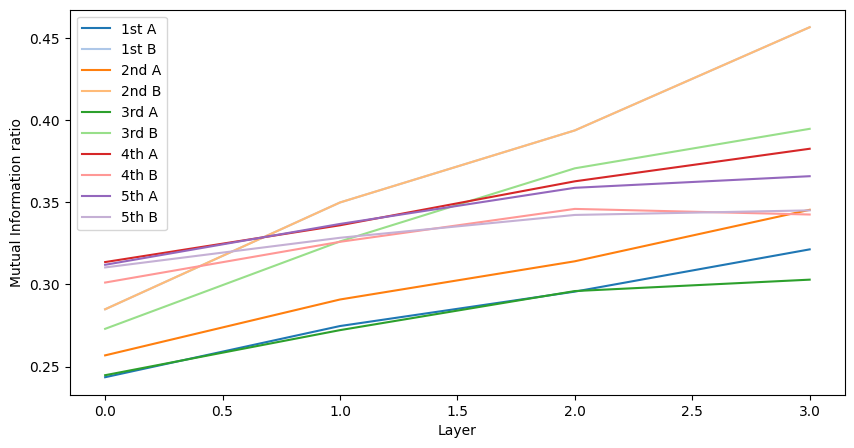

In [18]:
# Plot the mutual information scores
# Set tab20 colormap
cmap = plt.get_cmap("tab20")

plt.figure(figsize=(10, 5))
plt.plot(mi_scores_first_A[::4]/first_move_entropy_A, label="1st A", color=cmap(0))
plt.plot(mi_scores_first_B[::4]/first_move_entropy_B, label="1st B", color=cmap(1))
plt.plot(mi_scores_second_A[::4]/second_move_entropy_A, label="2nd A", color=cmap(2))
plt.plot(mi_scores_second_B[::4]/second_move_entropy_B, label="2nd B", color=cmap(3))
plt.plot(mi_scores_third_A[::4]/third_move_entropy_A, label="3rd A", color=cmap(4))
plt.plot(mi_scores_third_B[::4]/third_move_entropy_B, label="3rd B", color=cmap(5))
plt.plot(mi_scores_fourth_A[::4]/fourth_move_entropy_A, label="4th A", color=cmap(6))
plt.plot(mi_scores_fourth_B[::4]/fourth_move_entropy_B, label="4th B", color=cmap(7))
plt.plot(mi_scores_fifth_A[::4]/fifth_move_entropy_A, label="5th A", color=cmap(8))
plt.plot(mi_scores_fifth_B[::4]/fifth_move_entropy_B, label="5th B", color=cmap(9))
plt.xlabel("Layer")
plt.ylabel("Mutual Information ratio")
plt.legend()
plt.show()

In [160]:
mutual_information_PCA(np.array(second_moves_B)[fifth_moves_B_index], fifth_moves_B)/fifth_move_entropy_B

0.28988246375583865

# Simple PCA plot

In [54]:
boards = []
board_labels = []
good_puzzles = []
for i in range(len(puzzles)):
    puzzle = puzzles.iloc[i]
    pv = puzzle.principal_variation
    mov_1, mov_2, mov_3 = pv[0], pv[1], pv[2]
    # if len(pv) > 3:
    #     mov_4 = pv[3]
    #     mov_5 = pv[4]
    if mov_1[2:4] != mov_2[2:4]:
        continue
    # if mov_1[2:4] != 'f1' and mov_1[2:4] != 'e8':
    #     continue
    check = mov_1[2:4] + mov_3[2:4]
    # if len(pv) > 3:
    #     check += mov_4[:4] + mov_5[:4]
    #     print(i, pv)
    if check != 'c8e8' and check != 'f7e8' and check != 'c8c8':
        continue
    board_labels.append(check)
    good_puzzles.append(puzzle)
    # LeelaBoard instances can also be created from FENs or in other ways, but always
    # use from_puzzle if you want to create one from a puzzle from the lichess dataset.
    board = LeelaBoard.from_puzzle(puzzle)
    boards.append(board)

In [55]:
len(boards)

360

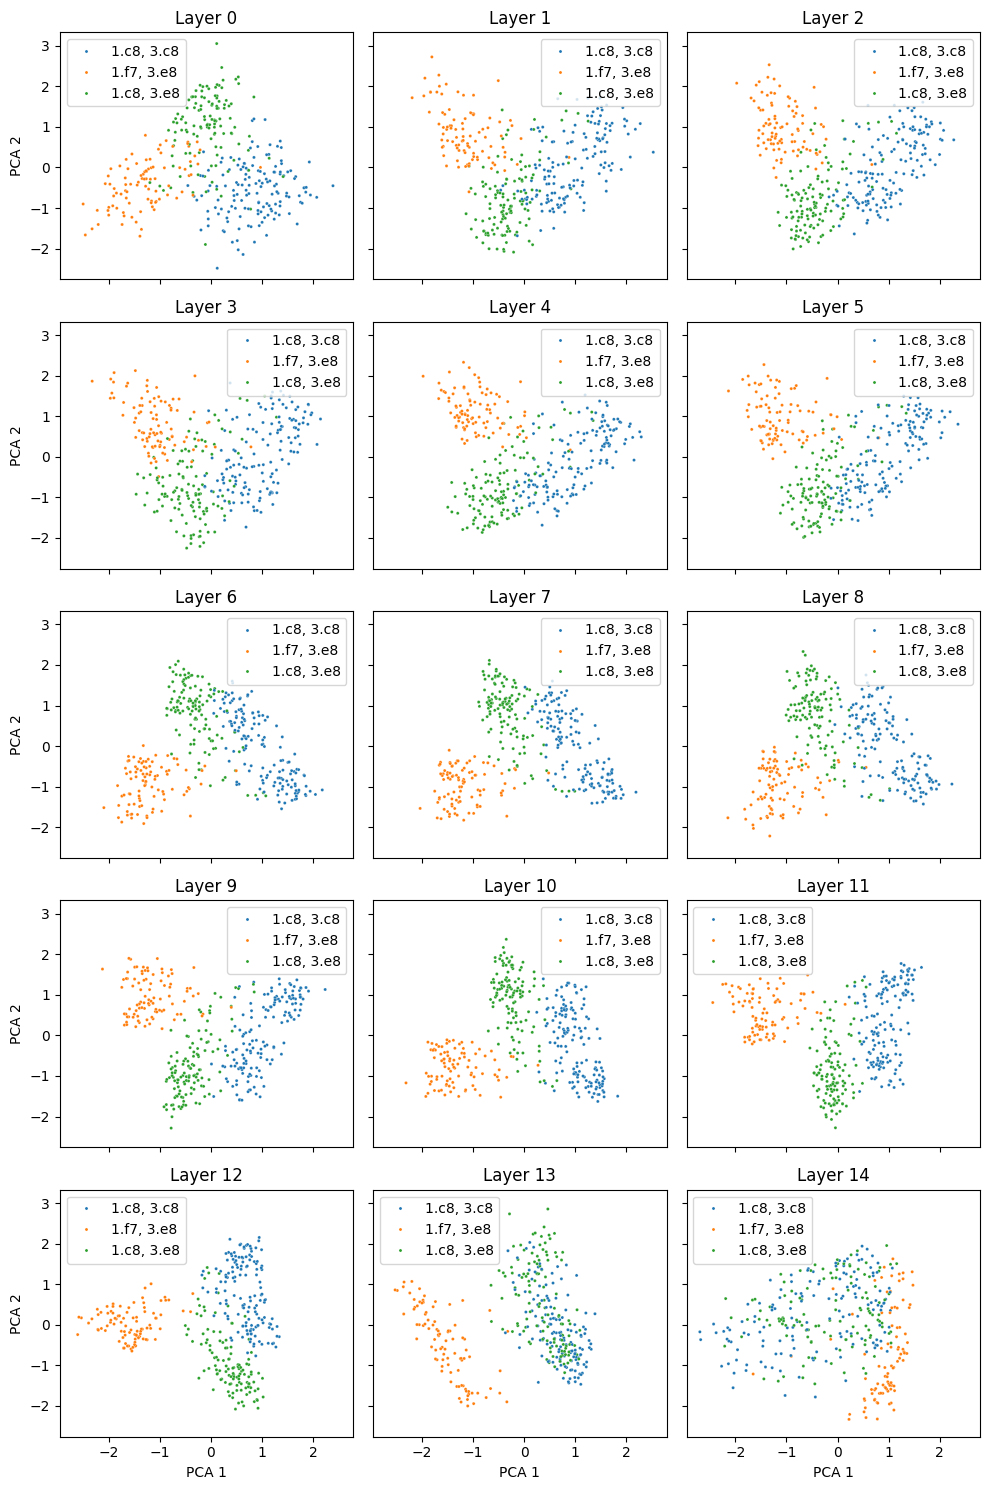

In [59]:
# Plot PCA of attention values for each layer in a 5 x 3 grid
fig, axs = plt.subplots(5, 3, figsize=(10, 15), sharex=True, sharey=True)

for layer in range(0, 15):
    with model.trace(boards):
        attention = model.residual_stream(layer).output.save()
    attention_dist = attention.reshape(attention.shape[0], -1)
    pca = PCA(n_components=2, whiten=True, random_state=42)
    pca.fit(attention_dist)
    attention_pca = pca.transform(attention_dist)

    ax = axs[layer // 3, layer % 3]
    sns.scatterplot(x=attention_pca[:, 0], y=attention_pca[:, 1], hue=[f'1.{label[:2]}, 3.{label[2:4]}' for label in board_labels], ax=ax, s=5)
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

# Save PDF of plot with tight layout
fig.savefig("pca.pdf", bbox_inches="tight")

In [64]:
# MI scores for each layer
n_layers = 15
PCA_comps = [2, 4, 8]
clusters = [2, 4, 8, 16]
mi_scores_first = np.zeros((len(PCA_comps), len(clusters), n_layers))
mi_scores_third = np.zeros((len(PCA_comps), len(clusters), n_layers))

for i, layer in enumerate(range(n_layers)):
    with model.trace(boards):
        attention = model.residual_stream(layer).output.save()
    attention_dist = attention.reshape(attention.shape[0], -1)

    # Perform PCA on the attention values
    for j, n_components in enumerate(PCA_comps):

        pca = PCA(n_components=n_components)
        pca.fit(attention_dist)
        attention_pca = pca.transform(attention_dist)

        # Perform KMeans clustering on the original (unsorted) PCA results
        for k, n_clusters in enumerate(clusters):
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            cluster_labels = kmeans.fit_predict(attention_pca)
            mi_scores_first[j, k, layer] = mutual_information_PCA(cluster_labels, [label[:2] for label in board_labels])
            mi_scores_third[j, k, layer] = mutual_information_PCA(cluster_labels, [label[2:4] for label in board_labels])

In [65]:
# Entropy of first and third moves
first_move_entropy = entropy([v for k,v in Counter([label[:2] for label in board_labels]).items()], base=2)
third_move_entropy = entropy([v for k,v in Counter([label[2:4] for label in board_labels]).items()], base=2)
first_move_entropy, third_move_entropy

(0.819965310218763, 0.9741077610898748)

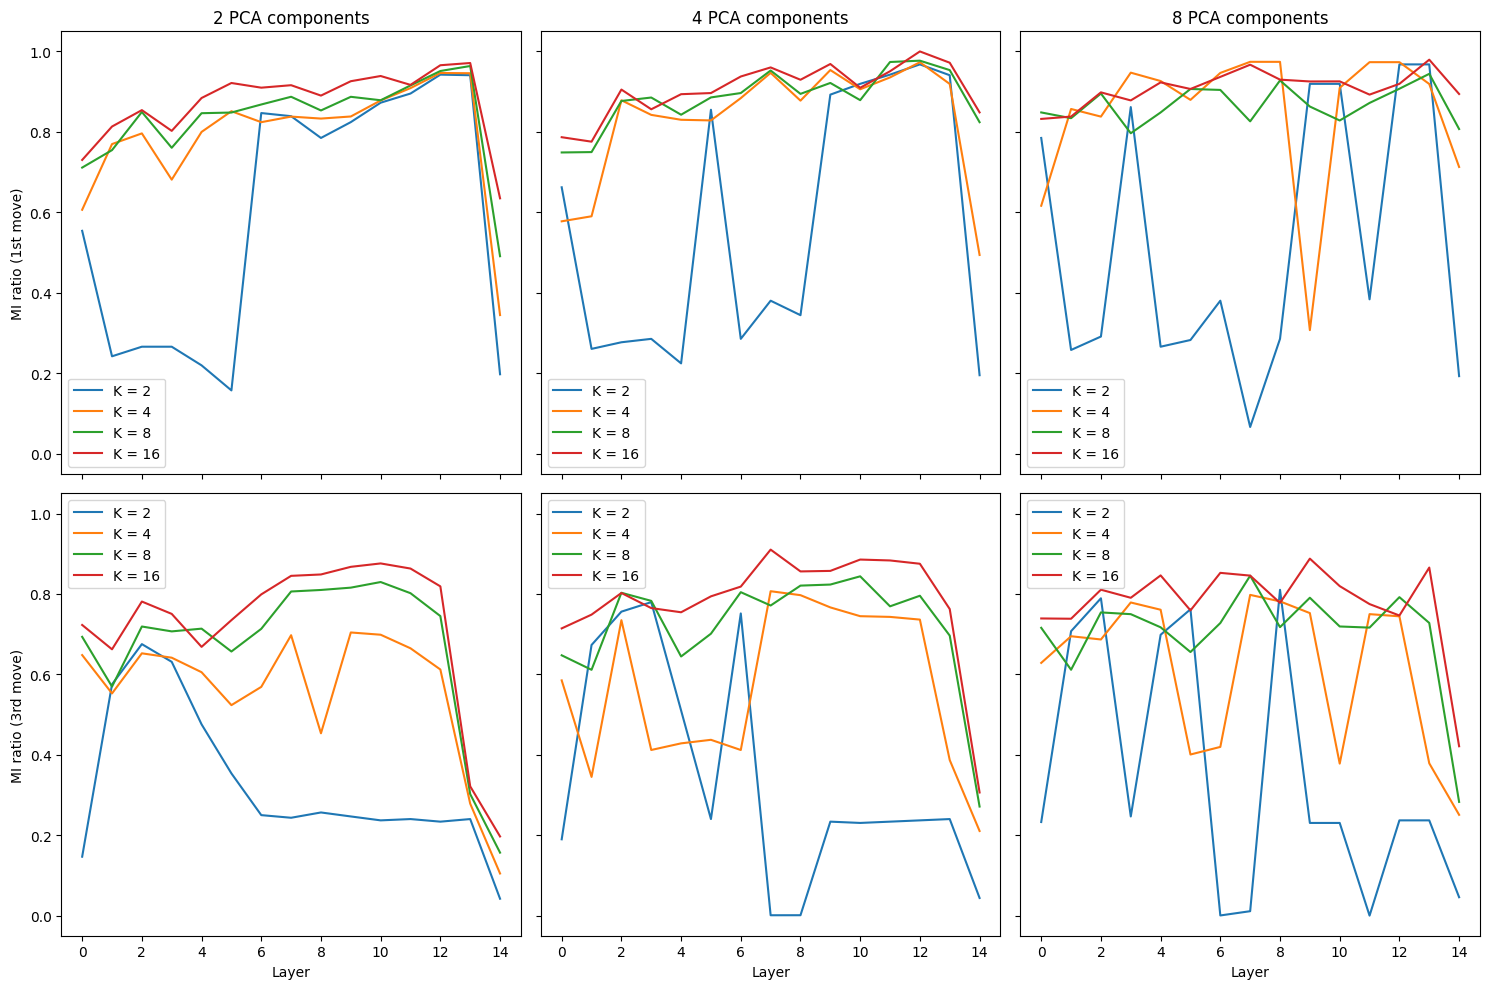

In [69]:
# Plot MI scores
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
cmap = plt.get_cmap("tab10")
for i, n_components in enumerate(PCA_comps):
    for j, n_clusters in enumerate(clusters):
        axs[0, i].plot(mi_scores_first[i, j] / first_move_entropy, label=f"K = {n_clusters}", color=cmap(j))
        axs[1, i].plot(mi_scores_third[i, j] / third_move_entropy, label=f"K = {n_clusters}", color=cmap(j))
        axs[0, i].set_title(f"{n_components} PCA components")
        axs[1, i].set_xlabel("Layer")
        if i == 0:
            axs[0, i].set_ylabel("MI ratio (1st move)")
            axs[1, i].set_ylabel("MI ratio (3rd move)")
        axs[0, i].legend()
        axs[1, i].legend()

plt.tight_layout()
plt.show()

# Save PDF of plot with tight layout
fig.savefig("mi_toy_pca.pdf", bbox_inches="tight")

# Other code

In [7]:
layer = 9
head = 5

# We're using nnsight to cache activations and do interventions. There's also an interface
# based directly on pytorch hooks if you prefer that, see Lc0Model.capturing().
with model.trace(board):
    attention = model.attention_scores(layer).output[0, head].save()
attention.shape

torch.Size([64, 64])

We can plot slices of this attention pattern:

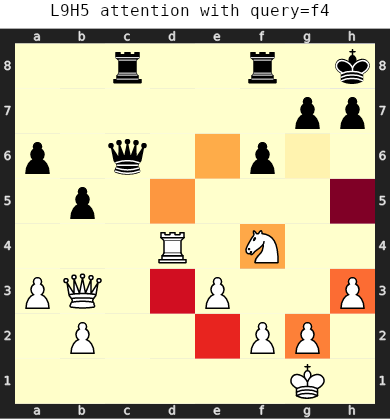

In [9]:
square = "f4"
# This converts a square in chess notation to the index inside Leela's activations for
# that square. Note that the input to Leela is flipped depending on the current player's
# color.
idx = board.sq2idx(square)
# attention has shape (query_dim, key_dim); indexing into the first one gives us a slice
# of the attention pattern with fixed query.
board.plot(attention[idx], caption=f"L{layer}H{head} attention with query={square}")

# Attention attribution

Let's look at L12H12 instead and do attention attribution (this is basically approximating a zero-ablation of individual attention weights). We'll then plot the entries with the highest attribution scores as arrows from key to query (i.e. in the direction of information flow).

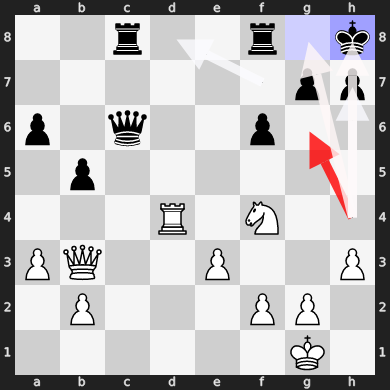

In [10]:
attribution = attention_attribution(
    [board], layer=12, head=12, model=model, return_pt=True
)[0]
values, colors = top_k_attributions(attribution, board, k=5)
board.plot(arrows=colors)

As discussed in the paper, it seems L12H12 is moving information from the 3rd move target square (h4) to the 1st move target (g6). Let's see what happens if we zero-ablate this single attention pattern entry:

In [11]:
query_square = puzzle.principal_variation[0][2:4]
key_square = puzzle.principal_variation[2][2:4]
query_idx = board.sq2idx(query_square)
key_idx = board.sq2idx(key_square)

with model.trace(board):
    model.attention_scores(12).output[0, 12, query_idx, key_idx] = 0
    output = model.output.save()

probs = model.logits_to_probs(board, output[0])[0]
policy = model.top_moves(board, probs, top_k=5)
print(policy)
print("WDL:", output[1])

{'a3a4': 0.1945486217737198, 'g1h2': 0.18257927894592285, 'h3h4': 0.16615907847881317, 'f4g6': 0.1618361473083496, 'b3d3': 0.07064691931009293}
WDL: tensor([[0.0993, 0.4908, 0.4100]])


The previous top move, Ng6, is now in 4th place at only 16%. Leela also thinks it's worse (the win probability is down to 9.9% from 28.7%).

# Activation patching

Finally, let's do activation patching. Every puzzle in our dataset already has a "corrupted version" that we automatically generated. This is a very similar board position, but with a slight difference that makes the tactic no longer work. Note the new pawn on h6:

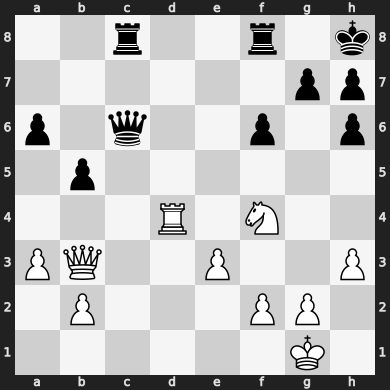

a4: 23.92%
Kh2: 23.56%
Qb4: 13.59%
Qd3: 6.72%
Ne6: 4.85%
W: 1.32%, D: 10.89%, L: 87.79%


In [12]:
corrupted_board = LeelaBoard.from_fen(puzzle.corrupted_fen)
display(corrupted_board)
model.pretty_play(corrupted_board)

We could implement activation patching fairly easily with `nnsight`, but we'll instead introduce our patching helper function. Let's patch the output of L12H12 on every square:

In [13]:
log_odds_reductions = -activation_patch(
    module_func=model.headwise_attention_output,
    # Layer, head, output square:
    locations=list(itertools.product([12], [12], range(64))),
    model=model,
    # We could also pass in board and corrupted_board manually instead
    puzzles=puzzle,
)
log_odds_reductions.shape

100%|██████████| 64/64 [00:02<00:00, 25.23it/s]


torch.Size([64])

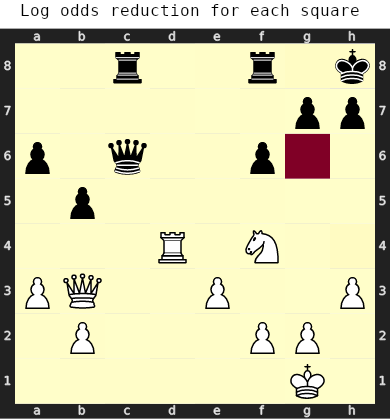

In [14]:
board.plot(log_odds_reductions, caption="Log odds reduction for each square")

As we can see, activation patching essentially only has a big effect on g6, where L12H12 moved information to from h4.

# Next steps
We demonstrated how to use several mechanistic interpretability techniques on a single board position. It's fairly straightforward to extend these to batches of positions, see the files in `scripts` for examples. `nnsight` also makes it quite easy to use other interpretability techniques that we didn't cover here.